In [76]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

Arima is statiscal method where you use past data to predict the future 

Trend and Cycle are important for consideration when you want to do Time series

Auto regresive model 

for splitting you can not just randomnly select you
any error will expoential increase 

>Quantitative analyist task

In [77]:
BASE_DIR = Path.cwd()
data_path = BASE_DIR / 'data'

# Verify the path and file existence
print(f'Base directory: {BASE_DIR}')
print(f'Data file path: {data_path}')
print(f'Data file exists: {data_path.exists()}')

Base directory: /Users/femiir/dev/odyssey/machine_learning/time_series
Data file path: /Users/femiir/dev/odyssey/machine_learning/time_series/data
Data file exists: True


In [78]:
# Load the dataset
df = pd.read_csv(data_path / 'Alcohol_Sales.csv', index_col='DATE')
df.head()

,S4248SM144NCEN
DATE,
01/01/1992,3459
01/02/1992,3458
01/03/1992,4002
01/04/1992,4564
01/05/1992,4221


In [79]:
g = np.arange(0, 10, 2)
g

array([0, 2, 4, 6, 8])

In [80]:
g = g.reshape(1, 5, 1)

In [81]:
b = np.array([22])
b.shape

(1,)

In [82]:
g = np.append(g[:, 1:, :], [[b]], axis=1)

In [83]:
df.index.freq = 'MS'

In [84]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
01/01/1992,3459
01/02/1992,3458
01/03/1992,4002
01/04/1992,4564
01/05/1992,4221


<Axes: title={'center': 'Alcohol Sales'}, xlabel='DATE'>

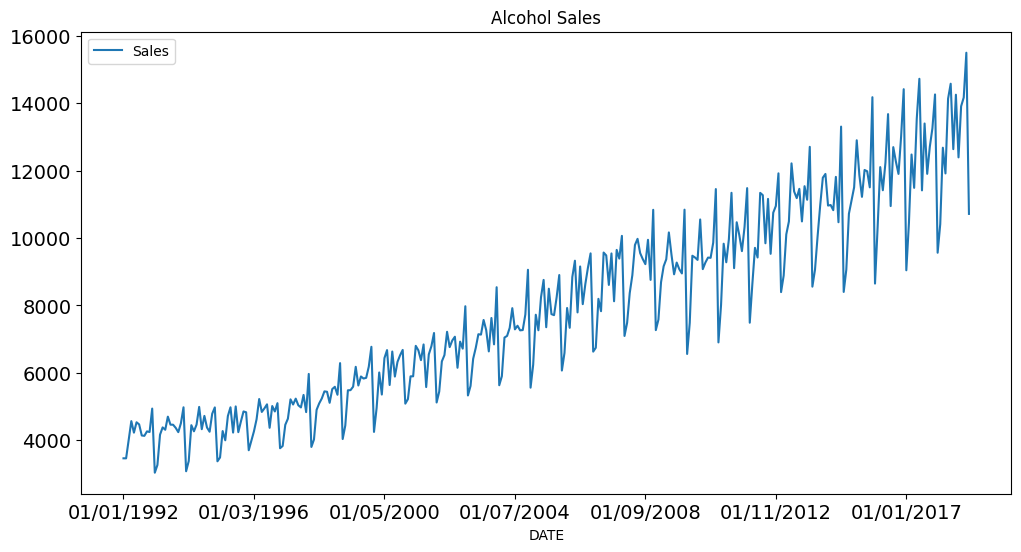

In [85]:
df.plot(figsize=(12, 6), title='Alcohol Sales', fontsize=14)

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [87]:
res = seasonal_decompose(df['Sales'], period=12)

<Figure size 1000x4000 with 0 Axes>

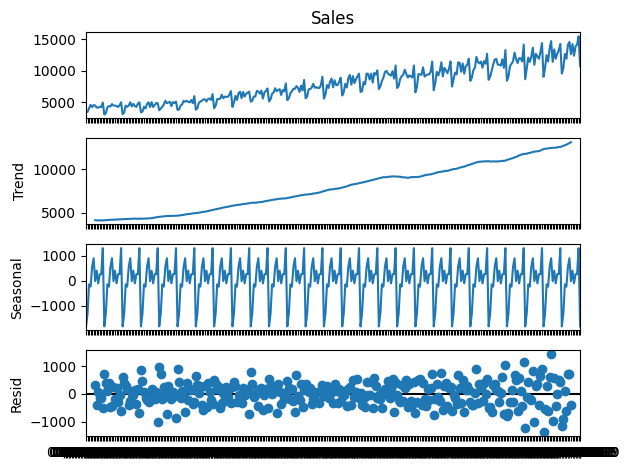

In [88]:
plt.figure(figsize=(10, 40))
res.plot()
plt.show()

In [89]:
df.shape

(325, 1)

In [90]:
train = df.iloc[:313]
train.shape

(313, 1)

In [91]:
test = df.iloc[313:]
test.shape

(12, 1)

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [93]:
scaler.fit(train)

MinMaxScaler()

In [94]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Go with the time series generator from Tensorflow

In [111]:
import tensorflow as tf

In [96]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [97]:
n_input = 12
n_features = 1

In [98]:
generator = TimeseriesGenerator(
	scaled_train, scaled_train, length=n_input, batch_size=1
)
len(generator)

301

In [99]:
generator[0]

(array([[[0.03658432],
         [0.03649885],
         [0.08299855],
         [0.13103684],
         [0.1017181 ],
         [0.12804513],
         [0.12266006],
         [0.09453799],
         [0.09359774],
         [0.10496624],
         [0.10334217],
         [0.16283443]]]),
 array([[0.]]))

In [106]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input

In [103]:
model = Sequential()
model.add(Input(shape=(n_input, n_features)))
model.add(LSTM(180, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))

2025-04-11 12:31:15.776859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-11 12:31:15.777193: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-11 12:31:15.777203: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-11 12:31:15.777970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-11 12:31:15.778664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [107]:
# functional API
input_layer = Input(shape=(n_input, n_features), name='input_layer')
x = LSTM(180, activation='relu', name='lstm_layer')(input_layer)
output_layer = Dense(1, name='output_layer')(x)

# create the model
model = Model(inputs=input_layer, outputs=output_layer, name='functional_lstm_model')

In [108]:
model.summary()

Model: "functional_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 180)            │       131,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,221 (512.58 KB)

 Trainable params: 131,221 (512.58 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [113]:
import time

In [114]:
start = time.time()
history = model.fit(generator, epochs=10, verbose=1)

end = time.time()
print(f'Time taken to train the model: {end - start} seconds')

Epoch 1/10


/opt/homebrew/Caskroom/miniforge/base/envs/deeplearn/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-11 12:39:38.582005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


301/301 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - loss: 0.0317
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - loss: 0.0120
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - loss: 0.0076
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - loss: 0.0082
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0066
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - loss: 0.0051
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0044
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - loss: 0.0030
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - loss: 0.0026
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0022
Time taken to train the model: 364.9492859840393 seconds


<Axes: title={'center': 'Model Loss'}>

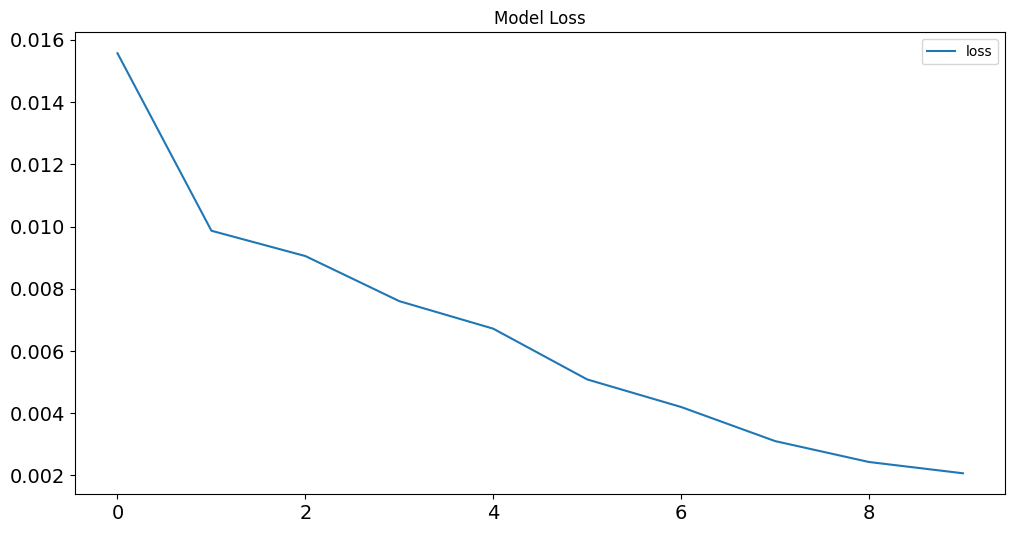

In [115]:
pd.DataFrame(history.history).plot(figsize=(12, 6), title='Model Loss', fontsize=14)

In [118]:
first_real_batch = scaled_train[-n_input:]

In [119]:
first_real_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [120]:
first_real_batch = first_real_batch.reshape((1, n_input, n_features))
first_real_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [121]:
first_real_batch = scaled_train[-n_input:]
test_preds = []
first_eval = scaled_train[-n_input:]
current_batch = first_real_batch
for i in range(len(test)):
	spot_pred = model.predict(current_batch)[0]
	test_preds.append(spot_pred)
	current_batch = np.append(current_batch[:, 1:, :], [[spot_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [116]:
# Check available devices
physical_devices = tf.config.list_physical_devices()
print('Available devices:', physical_devices)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
